In [119]:
!pip install pyclustertend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 68.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... canceled
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 92, in resolve
    result = self._result = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = r

In [157]:
import pandas as pd
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import pathlib
from scipy.cluster import hierarchy
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

Carregando os dados de cada Medidor com os atributos agrupados por estação do ano

In [158]:
df = pd.read_csv('dados_agrupados_por_estacao_do_ano.CSV', sep=';')
df = df[df.Medidor!='A252']

#Converter colunas específicas de string para float
colunas_numericas = ['Precipitacao Media Verao', 'Precipitacao Media Primavera', 'Precipitacao Media Inverno', 'Precipitacao Media Outono',
                     'Pressao Media Verao', 'Pressao Media Primavera', 'Pressao Media Inverno', 'Pressao Media Outono',
                     'Radiacao Media Verao', 'Radiacao Media Primavera', 'Radiacao Media Inverno', 'Radiacao Media Outono',
                     'Temp Bulbo Seco Media Verao', 'Temp Bulbo Seco Media Primavera', 'Temp Bulbo Seco Media Inverno', 'Temp Bulbo Seco Media Outono']

for coluna in colunas_numericas:
    df[coluna] = df[coluna].str.replace(',', '.').astype(float)

#Normalizando
df_normalizado=(df-df.mean(numeric_only=True))/df.std(numeric_only=True)
df_normalizado['Medidor'] = df['Medidor']
df_normalizado.head()

,Medidor,Precipitacao Media Inverno,Precipitacao Media Outono,Precipitacao Media Primavera,Precipitacao Media Verao,Pressao Media Inverno,Pressao Media Outono,Pressao Media Primavera,Pressao Media Verao,Radiacao Media Inverno,Radiacao Media Outono,Radiacao Media Primavera,Radiacao Media Verao,Temp Bulbo Seco Media Inverno,Temp Bulbo Seco Media Outono,Temp Bulbo Seco Media Primavera,Temp Bulbo Seco Media Verao
0,A848,1.744944,1.292215,1.962898,0.384267,0.396292,0.345107,-0.097702,0.278840,-0.260626,0.088462,0.214892,0.353409,-0.716526,-0.701422,-0.348458,-0.012561
1,A871,0.413997,-0.111726,0.314820,-0.087753,0.131526,-0.103352,-0.065605,-0.047851,-0.222324,-0.265515,0.017207,-0.007447,-0.528164,-0.706286,-0.459471,-0.276650
2,A765,0.452804,1.442188,0.706461,0.875776,-0.657097,-0.624986,-0.224437,-2.114332,-0.622644,-0.491118,-0.699002,-0.722508,-0.943965,-0.722307,-1.396015,-1.987483
3,A624,0.124274,0.184231,1.878992,1.380078,0.283365,0.237882,-0.088024,0.215464,-0.069600,-0.083918,-0.090461,0.173909,-1.162114,-1.004744,-1.000881,-0.655825
4,A567,-0.430869,-0.760755,0.874697,0.902611,0.352121,0.227466,-0.115031,-0.149452,0.160517,0.147467,0.239672,-0.067152,-0.115743,-0.246075,-0.172802,-0.470490


In [159]:
stations_data_path = pathlib.Path("STATION_DATA.CSV")
stations_info_df = pd.read_csv(stations_data_path, sep=";")

stations_info_df.head()

,REGIAO,UF,MUNICIPIO,CODIGO,LATITUDE,LONGITUDE,ALTITUDE
0,CO,DF,AGUAS EMENDADAS,A045,"-15,59638888","-47,62583332",1200
1,CO,DF,BRASILIA,A001,"-15,78944444","-47,92583332","1159,54"
2,CO,DF,BRAZLANDIA,A042,"-15,59972221","-48,1311111",1143
3,CO,DF,GAMA (PONTE ALTA),A046,"-15,93527777","-48,13749999",990
4,CO,DF,PARANOA (COOPA-DF),A047,"-16,01111111","-47,5575",1043


In [160]:
def get_longitude(x):
    a = stations_info_df.query('CODIGO == @x')['LONGITUDE'].values[0]
    return float(a.replace(',', '.'))

def get_latitude(x):
    a = stations_info_df.query('CODIGO == @x')['LATITUDE'].values[0]
    return float(a.replace(',', '.'))

In [161]:
climate_background_img = plt.imread('mapa_trab2.png')

BBox = (-72.78666666, -29.31666666, -33.74166666, 4.47749999)

In [162]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

    kwargs.setdefault('no_labels', True)
    plt.xticks([])
    plt.title("Dendrograma da Aglomeração Hierárquica")
    plt.ylabel("Custo da Clusterização")

## Aglomeração Hierárquica

In [163]:
def testa_parametros_Agglomerative_Clustering(X):

    n_clusters = list(range(2, 11))
    linkages = ['single', 'average', 'complete']

    lista_resultados = []

    #VER SE TEM MAIS ALGUM PARAMETRO QUE POSSO VARIAR
    for n in n_clusters:
        for linkage in linkages:
            clustering = AgglomerativeClustering(linkage=linkage, n_clusters=n)

            #Ajustando o modelo aos dados
            classes_atribuidas = clustering.fit_predict(X)

            #Calcular a métrica Silhouette
            silhouette_avg = silhouette_score(X, classes_atribuidas)

            bouldin = metrics.davies_bouldin_score(
            X, classes_atribuidas)

            resultados_atuais = {'n':n, 'linkage':linkage, 'silhouette_avg':silhouette_avg, 'bouldin':bouldin}
            lista_resultados.append(resultados_atuais)

    return pd.DataFrame.from_records(lista_resultados)

In [164]:
def encontra_rotulos_Agglomerative_Clustering(linkage, n_clusters, X):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=n_clusters, distance_threshold=None)

    # Ajustando o modelo aos dados
    rotulos = clustering.fit_predict(X)

    return rotulos

## Aglomeração Hierárquica usando Precipitação

Buscando a melhor configuração usando silhouette_avg e bouldin

In [165]:
df_normalizado['Longitude'] = df_normalizado['Medidor'].apply(get_longitude)
df_normalizado['Latitude'] = df_normalizado['Medidor'].apply(get_latitude)

colunas_consideradas = ['Precipitacao Media Verao', 'Precipitacao Media Primavera', 'Precipitacao Media Inverno', 'Precipitacao Media Outono']

X = df_normalizado[colunas_consideradas].values

resultados_df = testa_parametros_Agglomerative_Clustering(X)

In [166]:
resultados_df

,n,linkage,silhouette_avg,bouldin
0,2,single,0.717330,0.327809
1,2,average,0.717330,0.327809
2,2,complete,0.717330,0.327809
3,3,single,0.605316,0.484048
4,3,average,0.605316,0.484048
5,3,complete,0.605316,0.484048
6,4,single,0.586889,0.419356
7,4,average,0.436276,0.782720
8,4,complete,0.323825,0.994956
9,5,single,0.490236,0.407022


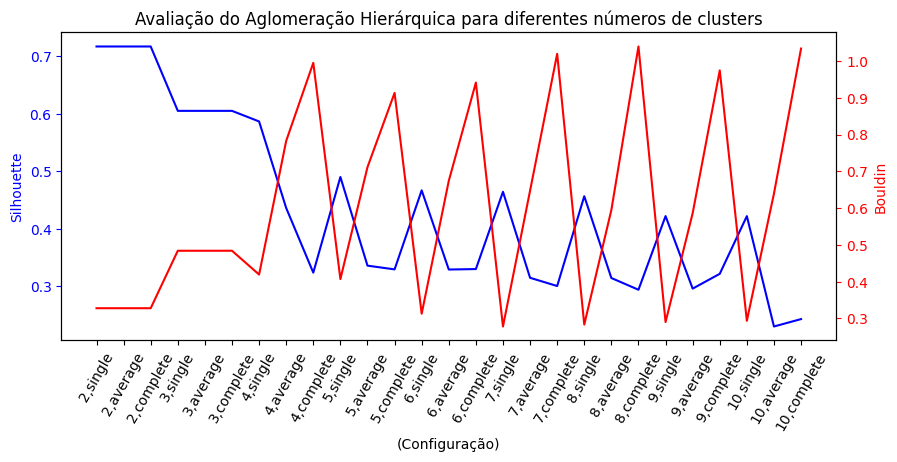

In [167]:
index_as_str_list = [str(el) for el in resultados_df.index]

fig, ax1 = plt.subplots(figsize=(10, 4))
sns.lineplot(data=resultados_df, x=index_as_str_list, y='silhouette_avg', ax=ax1, color='b')
plt.xticks(rotation=60)
ax1.set_ylabel('Silhouette', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
sns.lineplot(data=resultados_df, x=index_as_str_list, y='bouldin', ax=ax2, color='r')
ax2.set_ylabel('Bouldin', color='r')
ax2.tick_params('y', colors='r')

ax1.set_xlabel("(Configuração)")
plt.title("Avaliação do Aglomeração Hierárquica para diferentes números de clusters")
#plt.savefig("./assets/dbscan_avaliacao.png", bbox_inches='tight')
labels=[f"{n},{l}" for n,l in zip(resultados_df['n'].tolist(), resultados_df['linkage'].tolist())]
plt.xticks(range(len(resultados_df)),labels)
plt.show()

Visualizando no para os grupos formados pela configuração com a melhor medida de qualidade (2 clusters e single linkage)

<ipython-input-168-29d770da2b36>:6: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=df_normalizado, x='Longitude', y='Latitude', hue='Rotulos', ax=ax, s=15,


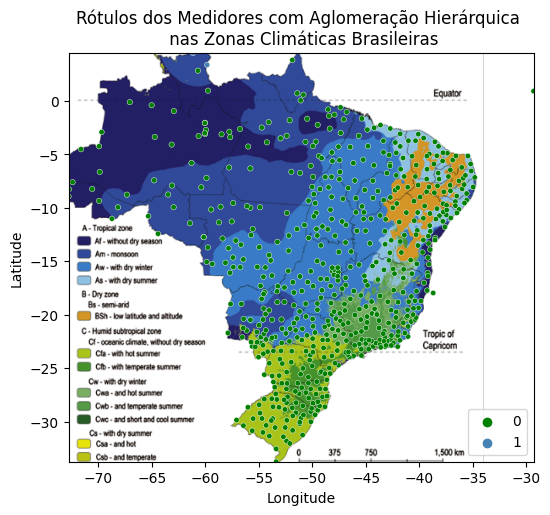

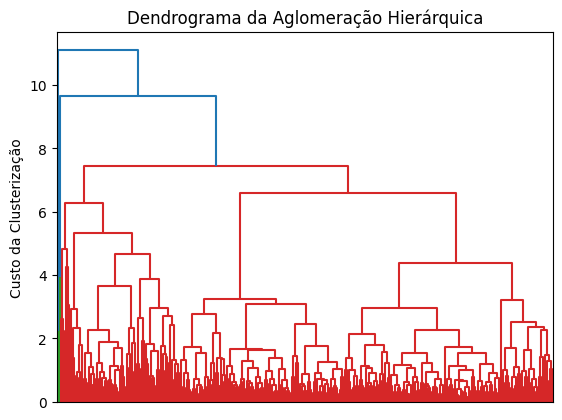

In [168]:
df_normalizado['Rotulos'] = encontra_rotulos_Agglomerative_Clustering('single',2,X)

cores = ['green', 'steelblue', 'salmon', 'red', 'darkgoldenrod','darkviolet']

fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(data=df_normalizado, x='Longitude', y='Latitude', hue='Rotulos', ax=ax, s=15,
                palette=cores)
ax.set_title('Rótulos dos Medidores com Aglomeração Hierárquica \n nas Zonas Climáticas Brasileiras')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
img_bbox = (-72.78666666, -34.0, -34.0, 4.47749999)
ax.imshow(climate_background_img, zorder=0, extent = img_bbox, aspect= 'equal')
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.legend(loc='lower right')
plt.show()

clustering = AgglomerativeClustering(linkage='complete', n_clusters=None, distance_threshold=0)

# Ajustando o modelo aos dados
clustering.fit(X)

plot_dendrogram(clustering, truncate_mode="level")

Verificando o resultado para o Método do Cotovelo

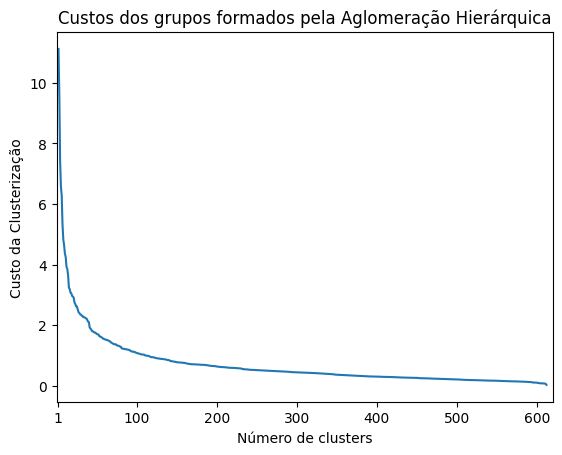

In [169]:
# Obtenha as distâncias do linkage
distances = clustering.distances_

# Plote o gráfico de cotovelo
plt.plot(range(len(distances)+1, 1, -1), distances)

plt.xlabel('Número de clusters')
plt.ylabel('Custo da Clusterização')
plt.title('Custos dos grupos formados pela Aglomeração Hierárquica')
plt.xlim((0,620))
plt.xticks([1,100,200,300,400,500,600], [1,100,200,300,400,500,600])
plt.show()

Testando outras configurações com maior número de clusters e diferentes tipos de linkage

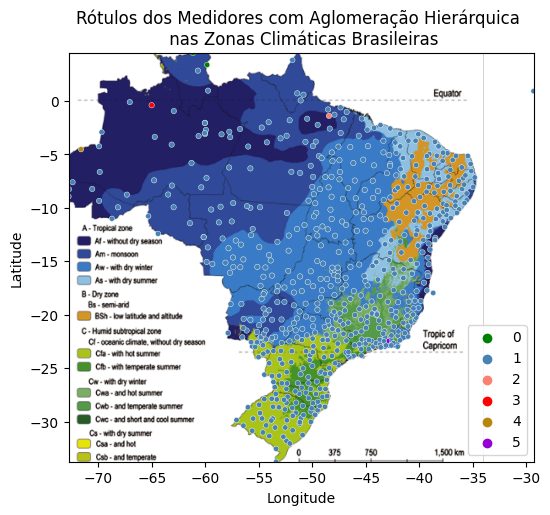

In [170]:
df_normalizado['Rotulos'] = encontra_rotulos_Agglomerative_Clustering('single',6,X)

cores = ['green', 'steelblue', 'salmon', 'red', 'darkgoldenrod','darkviolet']

fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(data=df_normalizado, x='Longitude', y='Latitude', hue='Rotulos', ax=ax, s=15,
                palette=cores)
ax.set_title('Rótulos dos Medidores com Aglomeração Hierárquica \n nas Zonas Climáticas Brasileiras')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
img_bbox = (-72.78666666, -34.0, -34.0, 4.47749999)
ax.imshow(climate_background_img, zorder=0, extent = img_bbox, aspect= 'equal')
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.legend(loc='lower right')
plt.show()

<ipython-input-171-1daffb84ef26>:6: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=df_normalizado, x='Longitude', y='Latitude', hue='Rotulos', ax=ax, s=15,


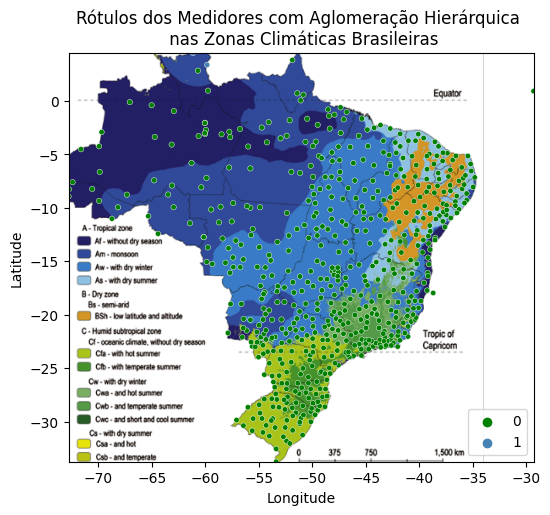

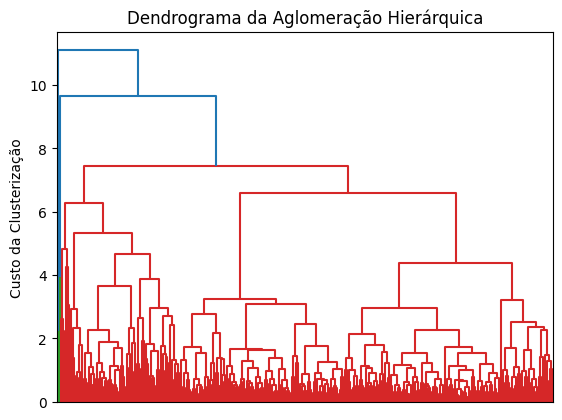

In [171]:
df_normalizado['Rotulos'] = encontra_rotulos_Agglomerative_Clustering('complete',2,X)

cores = ['green', 'steelblue', 'salmon', 'red', 'darkgoldenrod','darkviolet']

fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(data=df_normalizado, x='Longitude', y='Latitude', hue='Rotulos', ax=ax, s=15,
                palette=cores)
ax.set_title('Rótulos dos Medidores com Aglomeração Hierárquica \n nas Zonas Climáticas Brasileiras')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
img_bbox = (-72.78666666, -34.0, -34.0, 4.47749999)
ax.imshow(climate_background_img, zorder=0, extent = img_bbox, aspect= 'equal')
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.legend(loc='lower right')
plt.show()

clustering = AgglomerativeClustering(linkage='complete', n_clusters=None, distance_threshold=0)

# Ajustando o modelo aos dados
clustering.fit(X)

plot_dendrogram(clustering, truncate_mode="level")

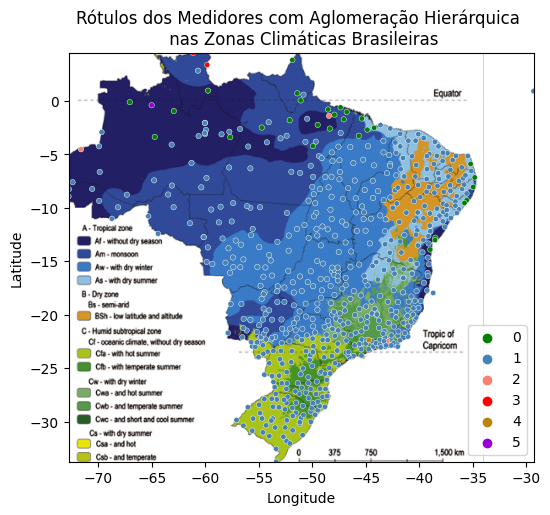

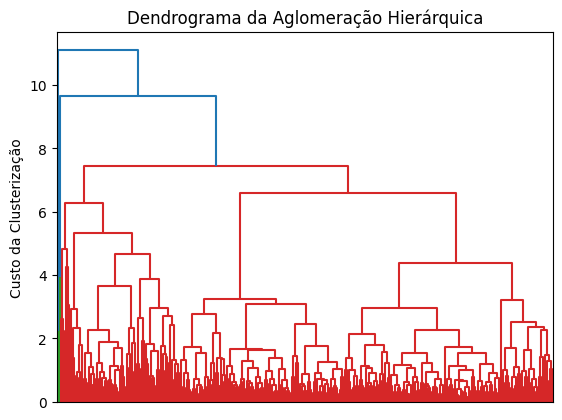

In [172]:
df_normalizado['Rotulos'] = encontra_rotulos_Agglomerative_Clustering('average',6,X)

cores = ['green', 'steelblue', 'salmon', 'red', 'darkgoldenrod','darkviolet']

fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(data=df_normalizado, x='Longitude', y='Latitude', hue='Rotulos', ax=ax, s=15,
                palette=cores)
ax.set_title('Rótulos dos Medidores com Aglomeração Hierárquica \n nas Zonas Climáticas Brasileiras')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
img_bbox = (-72.78666666, -34.0, -34.0, 4.47749999)
ax.imshow(climate_background_img, zorder=0, extent = img_bbox, aspect= 'equal')
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.legend(loc='lower right')
plt.show()

clustering = AgglomerativeClustering(linkage='complete', n_clusters=None, distance_threshold=0)

# Ajustando o modelo aos dados
clustering.fit(X)

plot_dendrogram(clustering, truncate_mode="level")

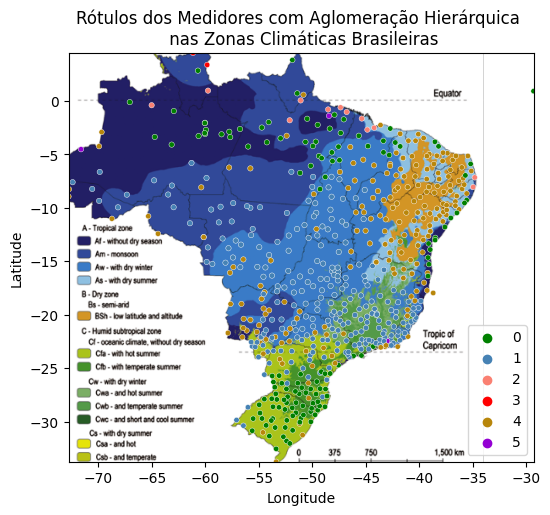

In [173]:
df_normalizado['Rotulos'] = encontra_rotulos_Agglomerative_Clustering('complete',6,X)

cores = ['green', 'steelblue', 'salmon', 'red', 'darkgoldenrod','darkviolet']

fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(data=df_normalizado, x='Longitude', y='Latitude', hue='Rotulos', ax=ax, s=15,
                palette=cores)
ax.set_title('Rótulos dos Medidores com Aglomeração Hierárquica \n nas Zonas Climáticas Brasileiras')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
img_bbox = (-72.78666666, -34.0, -34.0, 4.47749999)
ax.imshow(climate_background_img, zorder=0, extent = img_bbox, aspect= 'equal')
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.legend(loc='lower right')
plt.show()

## Usando k-means para 6 clusters

In [174]:
# Número de clusters desejado
k = 6

# Criar um objeto K-means
kmeans = KMeans(n_clusters=k)

# Ajustar o modelo aos dados
kmeans.fit(X)

# Obter os rótulos dos clusters para cada ponto de dados
df_normalizado['Rotulos'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


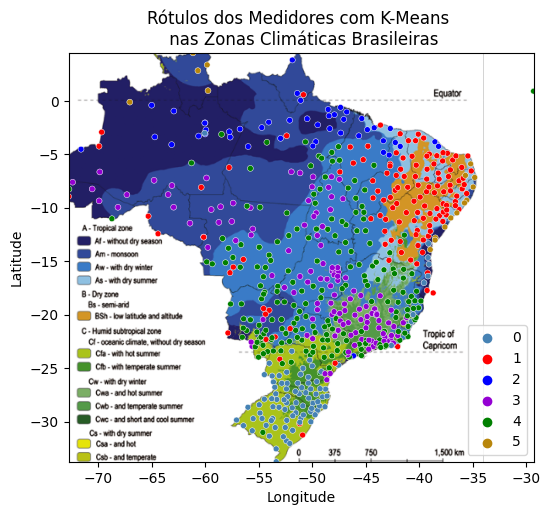

In [175]:
cores = ['steelblue', 'red', 'blue', 'darkviolet', 'green', 'darkgoldenrod']

fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(data=df_normalizado, x='Longitude', y='Latitude', hue='Rotulos', ax=ax, s=18,
                palette=cores)
ax.set_title('Rótulos dos Medidores com K-Means \n nas Zonas Climáticas Brasileiras')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
img_bbox = (-72.78666666, -34.0, -34.0, 4.47749999)
ax.imshow(climate_background_img, zorder=0, extent = img_bbox, aspect= 'equal')
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.legend(loc='lower right')
plt.show()

## Tentando uma abordagem PCA

In [176]:
# Separar as colunas de características
features = df_normalizado.drop(['Medidor', 'Longitude', 'Latitude', 'Rotulos'], axis=1)

# Aplicar o PCA
pca = PCA()
pca.fit(features)

# Obter os coeficientes de importância das características em relação aos componentes principais
feature_importance = pca.components_

# Criar um DataFrame para visualizar os coeficientes de importância
feature_names = features.columns
component_names = ['Componente {}'.format(i + 1) for i in range(len(pca.components_))]
importance_df = pd.DataFrame(data=feature_importance.T, columns=component_names, index=feature_names)

# Exibir os coeficientes de importância
print(importance_df)

# Variância explicada por cada componente principal
explained_variance = pca.explained_variance_ratio_

# Determinar o número de componentes principais a serem mantidos
num_components = 8  # Defina o número desejado de componentes principais

# Reduzir a dimensionalidade mantendo apenas os componentes principais selecionados
pca = PCA(n_components=num_components)
reduced_features = pca.fit_transform(features)

# Criar um novo DataFrame com as características reduzidas
reduced_data = pd.DataFrame(reduced_features, columns=[f"Componentes {i}" for i in range(1, 9)])

# Concatenar os valores do Medidor ao DataFrame reduzido (opcional)
reduced_data['Medidor'] = df_normalizado['Medidor']
reduced_data['Latitude'] = df_normalizado['Latitude']
reduced_data['Longitude'] = df_normalizado['Longitude']

                                 Componente 1  Componente 2  Componente 3  \
Precipitacao Media Inverno           0.014034     -0.188277      0.448789   
Precipitacao Media Outono           -0.062395     -0.223616      0.272911   
Precipitacao Media Primavera        -0.021088     -0.129457      0.399270   
Precipitacao Media Verao            -0.062748     -0.158417      0.335457   
Pressao Media Inverno               -0.309850     -0.228137      0.049227   
Pressao Media Outono                -0.321352     -0.260244      0.103952   
Pressao Media Primavera              0.048769     -0.098896      0.169774   
Pressao Media Verao                 -0.292061     -0.234579      0.173291   
Radiacao Media Inverno              -0.279350      0.377394      0.083978   
Radiacao Media Outono               -0.291997      0.386118      0.110748   
Radiacao Media Primavera            -0.266854      0.401232      0.174877   
Radiacao Media Verao                -0.268451      0.379471      0.216387   

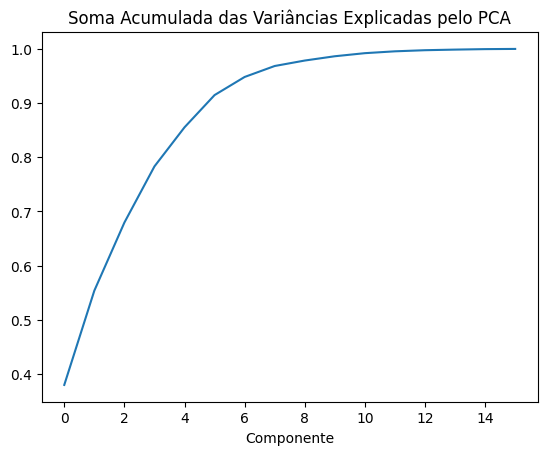

In [177]:
exp_np=np.array(explained_variance)
cum_sum=np.cumsum(exp_np)
plt.plot(range(len(cum_sum)), cum_sum)
plt.title('Soma Acumulada das Variâncias Explicadas pelo PCA')
plt.xlabel('Componente')
plt.show()

Para Aglomeração Hierárquica

In [178]:
X = reduced_data.drop(['Medidor', 'Longitude', 'Latitude'], axis=1)

resultados_df = testa_parametros_Agglomerative_Clustering(X)

In [179]:
resultados_df

,n,linkage,silhouette_avg,bouldin
0,2,single,0.799177,0.138211
1,2,average,0.799177,0.138211
2,2,complete,0.755558,0.736915
3,3,single,0.759950,0.155247
4,3,average,0.722655,0.560004
5,3,complete,0.676044,0.667447
6,4,single,0.667274,0.192331
7,4,average,0.672235,0.546038
8,4,complete,0.537057,0.740297
9,5,single,0.611146,0.279921


In [180]:
reduced_data['Rotulos'] = encontra_rotulos_Agglomerative_Clustering('single',2,X)

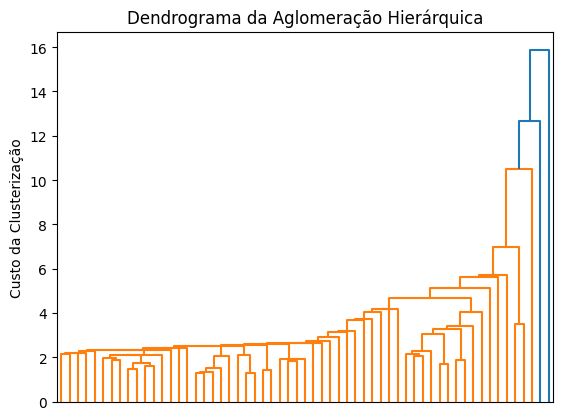

In [181]:
clustering = AgglomerativeClustering(linkage='single', n_clusters=None, distance_threshold=0)

# Ajustando o modelo aos dados
clustering.fit(X)

plot_dendrogram(clustering, truncate_mode="level")

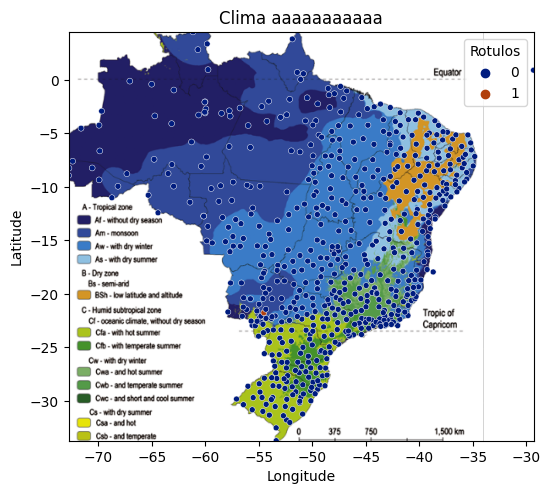

In [182]:
fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(data=reduced_data, x='Longitude', y='Latitude', hue='Rotulos', ax=ax, s=18,
                palette='dark')
ax.set_title('Clima aaaaaaaaaaa')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
img_bbox = (-72.78666666, -34.0, -34.0, 4.47749999)
ax.imshow(climate_background_img, zorder=0, extent = img_bbox, aspect= 'equal')
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.show()

In [183]:
reduced_data['Rotulos'] = encontra_rotulos_Agglomerative_Clustering('complete',6,X)

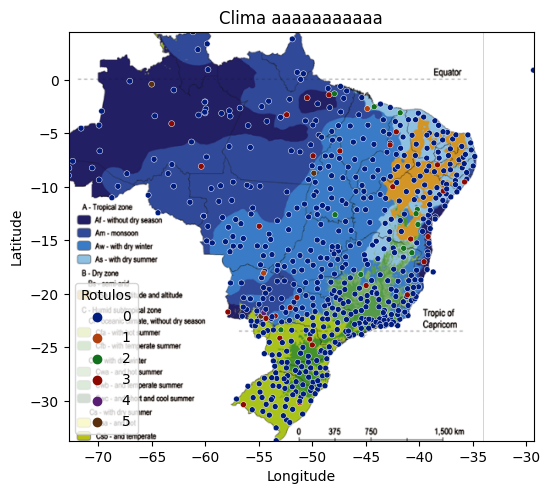

In [184]:
fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(data=reduced_data, x='Longitude', y='Latitude', hue='Rotulos', ax=ax, s=18,
                palette='dark')
ax.set_title('Clima aaaaaaaaaaa')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
img_bbox = (-72.78666666, -34.0, -34.0, 4.47749999)
ax.imshow(climate_background_img, zorder=0, extent = img_bbox, aspect= 'equal')
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.show()

Para K-Means

In [185]:
X = reduced_data.drop(['Medidor', 'Longitude', 'Latitude'], axis=1)

# Número de clusters desejado
k = 2

# Criar um objeto K-means
kmeans = KMeans(n_clusters=k)

# Ajustar o modelo aos dados
kmeans.fit(X)

# Obter os rótulos dos clusters para cada ponto de dados
reduced_data['Rotulos'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


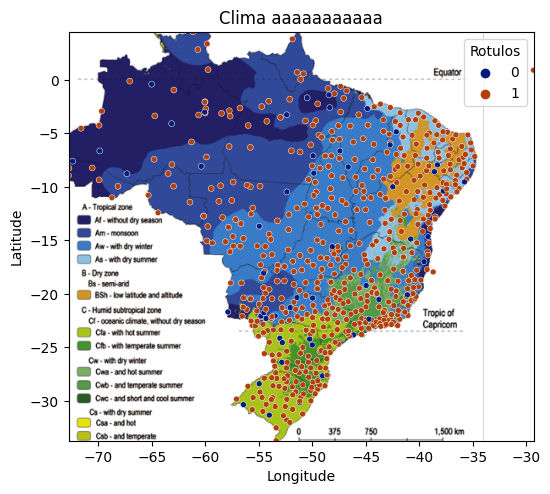

In [186]:
fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(data=reduced_data, x='Longitude', y='Latitude', hue='Rotulos', ax=ax, s=18,
                palette='dark')
ax.set_title('Clima aaaaaaaaaaa')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
img_bbox = (-72.78666666, -34.0, -34.0, 4.47749999)
ax.imshow(climate_background_img, zorder=0, extent = img_bbox, aspect= 'equal')
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.show()

In [187]:
X = reduced_data.drop(['Medidor', 'Longitude', 'Latitude'], axis=1)

# Número de clusters desejado
k = 6

# Criar um objeto K-means
kmeans = KMeans(n_clusters=k)

# Ajustar o modelo aos dados
kmeans.fit(X)

# Obter os rótulos dos clusters para cada ponto de dados
reduced_data['Rotulos'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


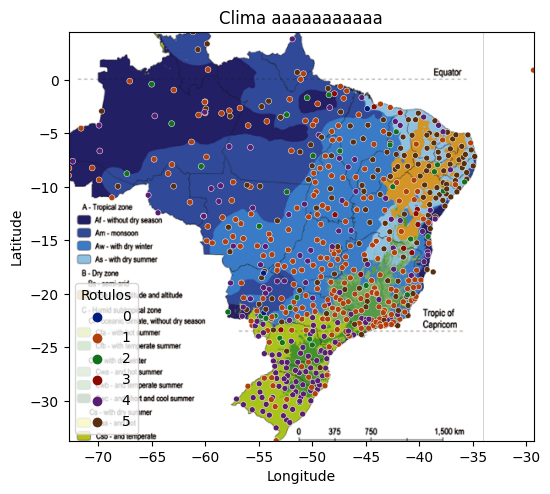

In [188]:
fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(data=reduced_data, x='Longitude', y='Latitude', hue='Rotulos', ax=ax, s=18,
                palette='dark')
ax.set_title('Clima aaaaaaaaaaa')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
img_bbox = (-72.78666666, -34.0, -34.0, 4.47749999)
ax.imshow(climate_background_img, zorder=0, extent = img_bbox, aspect= 'equal')
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.show()

## Testando outros subconjuntos de colunas

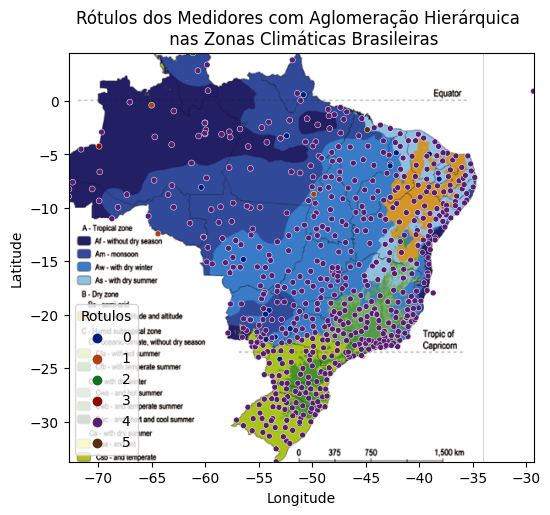

In [189]:
colunas_consideradas = ['Pressao Media Verao', 'Pressao Media Primavera', 'Pressao Media Inverno', 'Pressao Media Outono']

X = df_normalizado[colunas_consideradas].values

resultados_df = testa_parametros_Agglomerative_Clustering(X)

df_normalizado['Rotulos'] = encontra_rotulos_Agglomerative_Clustering('complete',6,X)

fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(data=df_normalizado, x='Longitude', y='Latitude', hue='Rotulos', ax=ax, s=18,
                palette='dark')
ax.set_title('Rótulos dos Medidores com Aglomeração Hierárquica \n nas Zonas Climáticas Brasileiras')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
img_bbox = (-72.78666666, -34.0, -34.0, 4.47749999)
ax.imshow(climate_background_img, zorder=0, extent = img_bbox, aspect= 'equal')
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.show()

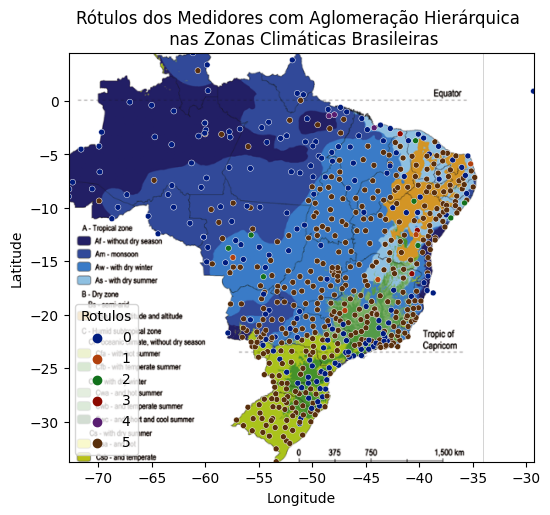

In [190]:
colunas_consideradas = ['Radiacao Media Verao', 'Radiacao Media Primavera', 'Radiacao Media Inverno', 'Radiacao Media Outono']

X = df_normalizado[colunas_consideradas].values

resultados_df = testa_parametros_Agglomerative_Clustering(X)

df_normalizado['Rotulos'] = encontra_rotulos_Agglomerative_Clustering('complete',6,X)

fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(data=df_normalizado, x='Longitude', y='Latitude', hue='Rotulos', ax=ax, s=18,
                palette='dark')
ax.set_title('Rótulos dos Medidores com Aglomeração Hierárquica \n nas Zonas Climáticas Brasileiras')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
img_bbox = (-72.78666666, -34.0, -34.0, 4.47749999)
ax.imshow(climate_background_img, zorder=0, extent = img_bbox, aspect= 'equal')
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.show()

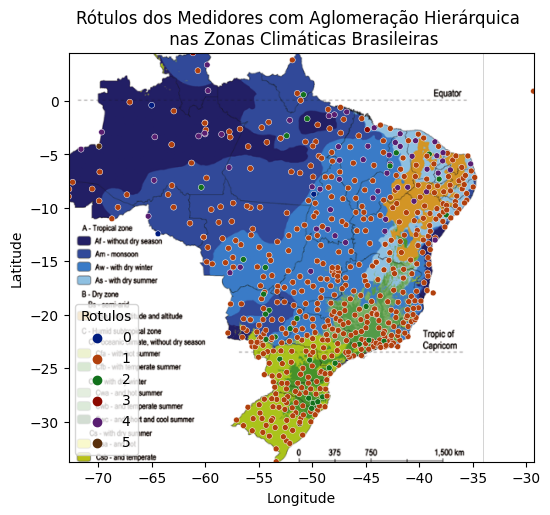

In [191]:
colunas_consideradas = ['Temp Bulbo Seco Media Verao', 'Temp Bulbo Seco Media Primavera', 'Temp Bulbo Seco Media Inverno', 'Temp Bulbo Seco Media Outono']

X = df_normalizado[colunas_consideradas].values

resultados_df = testa_parametros_Agglomerative_Clustering(X)

df_normalizado['Rotulos'] = encontra_rotulos_Agglomerative_Clustering('complete',6,X)

fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(data=df_normalizado, x='Longitude', y='Latitude', hue='Rotulos', ax=ax, s=18,
                palette='dark')
ax.set_title('Rótulos dos Medidores com Aglomeração Hierárquica \n nas Zonas Climáticas Brasileiras')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
img_bbox = (-72.78666666, -34.0, -34.0, 4.47749999)
ax.imshow(climate_background_img, zorder=0, extent = img_bbox, aspect= 'equal')
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.show()

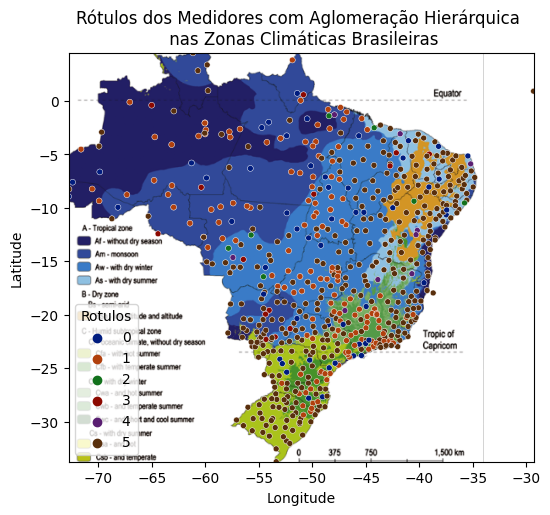

In [192]:
colunas_consideradas = ['Precipitacao Media Verao', 'Pressao Media Verao', 'Radiacao Media Verao', 'Temp Bulbo Seco Media Verao']

X = df_normalizado[colunas_consideradas].values

resultados_df = testa_parametros_Agglomerative_Clustering(X)

df_normalizado['Rotulos'] = encontra_rotulos_Agglomerative_Clustering('complete',6,X)

fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(data=df_normalizado, x='Longitude', y='Latitude', hue='Rotulos', ax=ax, s=18,
                palette='dark')
ax.set_title('Rótulos dos Medidores com Aglomeração Hierárquica \n nas Zonas Climáticas Brasileiras')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
img_bbox = (-72.78666666, -34.0, -34.0, 4.47749999)
ax.imshow(climate_background_img, zorder=0, extent = img_bbox, aspect= 'equal')
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.show()

##Extras

In [193]:
from sklearn import metrics

grid_search_params = {"eps":[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                      'min_samples':[3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}

def good_clusters(clusters_set:set):
    if -1 in clusters_set:
        clusters_set.remove(-1)

    return len(clusters_set) > 1

dbscan_results = dict()
for eps_v in grid_search_params['eps']:
    for min_samples_v in grid_search_params['min_samples']:
        clustering = DBSCAN(eps=eps_v, min_samples=min_samples_v, n_jobs=-1).fit(
            dados_normalizados
        )
        labels = clustering.labels_
        if not good_clusters(set(labels)):
            continue

        silhouette = metrics.silhouette_score(
            dados_normalizados, labels, metric='euclidean'
        )
        bouldin = metrics.davies_bouldin_score(
            dados_normalizados, labels)

        dbscan_results[(eps_v, min_samples_v)] = {"silhouette": silhouette,
                                                  'bouldin': bouldin, 'groups':len(set(labels))}



dbscan_results_df = pd.DataFrame.from_records(dbscan_results).T
dbscan_results_df

NameError: ignored

In [ ]:
import seaborn as sns

index_as_str_list = [str(el) for el in dbscan_results_df.index]

fig, ax1 = plt.subplots(figsize=(10, 4))
sns.lineplot(data=dbscan_results_df, x=index_as_str_list, y='silhouette', ax=ax1, color='b')
plt.xticks(rotation=60)
ax1.set_ylabel('Silhouette', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
sns.lineplot(data=dbscan_results_df, x=index_as_str_list, y='bouldin', ax=ax2, color='r')
ax2.set_ylabel('Bouldin', color='r')
ax2.tick_params('y', colors='r')

ax1.set_xlabel("(eps, min_samples)")
plt.title("DBSCAN: Avaliação do grid search")
#plt.savefig("./assets/dbscan_avaliacao.png", bbox_inches='tight')
plt.show()

In [ ]:
dbscan_results_df[dbscan_results_df['silhouette'] > 0.6]